<a href="https://colab.research.google.com/github/kri8tinam/Low-Resource-Deontic-Modality-Classification-in-EU-Legislation/blob/main/Human_Annotated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
#loading and visualizing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
import torch
import os
import random as rn

#preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#tokenization
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize


!pip install transformers
from transformers import AutoTokenizer, AutoModel

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks

!pip install keras_lr_finder
!pip install torch_optimizer

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from keras_lr_finder import LRFinder
# from clr_callback import CyclicLR


!pip install tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

!pip install keras-tuner
import keras_tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

from tensorflow.keras import regularizers
import time

# evaluation
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.5 MB/s eta 0:00:00
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.8 MB/s eta 0:00:00


<ipython-input-1-0d7e7f60ed9c>:53: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# Data Loading

In [63]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
human_data = pd.read_excel('/content/drive/MyDrive/human_annotated_data.xlsx')
test_data = pd.read_csv('/content/drive/MyDrive/TEST.csv', delimiter= ',')

Mounted at /content/drive


In [64]:
human_data

,Text,Deontic_modality (Obligation / Permission / Prohibition / Power / Right / None)
0,Organizations must ensure that their product l...,obligation
1,Organizations must ensure that their product t...,obligation
2,Organizations must ensure that their product p...,obligation
3,The Union shall ensure the right to protection...,obligation
4,Member States may adopt measures to limit acce...,power
...,...,...
296,Organizations must ensure that their contracts...,obligation
297,For a period of twenty-nine years from 1 Janua...,power
298,The Union shall ensure the freedom of establis...,obligation
299,For a period of thirty years from 1 October 20...,power


In [65]:
human_data.rename(columns={'Text': 'text'}, inplace=True)
human_data.rename(columns={'Deontic_modality (Obligation / Permission / Prohibition / Power / Right / None)': 'label'}, inplace=True)

In [66]:
human_data['label'].value_counts()

obligation            140
power                 111
right                  49
power / obligation      1
Name: label, dtype: int64

In [67]:
human_data[human_data['label'] == 'power / obligation']

,text,label
121,The Union shall take appropriate measures to c...,power / obligation


In [68]:
human_data['label'][121] = 'obligation'

In [69]:
human_data['label'][121]

'obligation'

In [70]:
human_data

,text,label
0,Organizations must ensure that their product l...,obligation
1,Organizations must ensure that their product t...,obligation
2,Organizations must ensure that their product p...,obligation
3,The Union shall ensure the right to protection...,obligation
4,Member States may adopt measures to limit acce...,power
...,...,...
296,Organizations must ensure that their contracts...,obligation
297,For a period of twenty-nine years from 1 Janua...,power
298,The Union shall ensure the freedom of establis...,obligation
299,For a period of thirty years from 1 October 20...,power


Text(0.5, 1.0, 'Number of provisions')

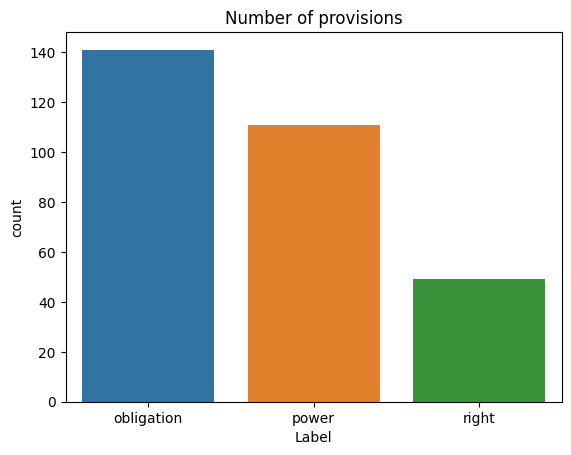

In [71]:
sns.countplot(x=human_data["label"])
plt.xlabel('Label')
plt.title('Number of provisions')

In [72]:
test_data

,text,category
0,Organizations must ensure that their product r...,obligations
1,For a period of thirty years from 1 October 20...,right
2,Member States may adopt measures to limit acce...,power
3,For a period of seventeen years from 1 October...,right
4,Organizations must ensure that their product r...,obligations
...,...,...
321,Member States may adopt measures to limit acce...,power
322,Organizations must ensure that their product a...,obligations
323,The Union shall ensure the right to protection...,prohibitions
324,For a period of twenty years from 1 November 2...,power


In [73]:
test_data.rename(columns={'category': 'label'}, inplace=True)

In [74]:
label_mapping = {'obligations': 'obligation', 'prohibitions': 'prohibition'}
test_data['label'] = test_data['label'].replace(label_mapping)
test_data

,text,label
0,Organizations must ensure that their product r...,obligation
1,For a period of thirty years from 1 October 20...,right
2,Member States may adopt measures to limit acce...,power
3,For a period of seventeen years from 1 October...,right
4,Organizations must ensure that their product r...,obligation
...,...,...
321,Member States may adopt measures to limit acce...,power
322,Organizations must ensure that their product a...,obligation
323,The Union shall ensure the right to protection...,prohibition
324,For a period of twenty years from 1 November 2...,power


In [75]:
test_data

,text,label
0,Organizations must ensure that their product r...,obligation
1,For a period of thirty years from 1 October 20...,right
2,Member States may adopt measures to limit acce...,power
3,For a period of seventeen years from 1 October...,right
4,Organizations must ensure that their product r...,obligation
...,...,...
321,Member States may adopt measures to limit acce...,power
322,Organizations must ensure that their product a...,obligation
323,The Union shall ensure the right to protection...,prohibition
324,For a period of twenty years from 1 November 2...,power


In [76]:
matches = pd.merge(test_data, human_data, on=['text', 'label'], how='inner')
matches

,text,label
0,Organizations must ensure that their product r...,obligation
1,Organizations must ensure that their product r...,obligation
2,Organizations must ensure that their product s...,obligation
3,Organizations must ensure that their privacy p...,obligation
4,Organizations must ensure that their anti-mone...,obligation
...,...,...
115,Organizations must ensure that their anti-trus...,obligation
116,Organizations must ensure that their tax pract...,obligation
117,Member States may adopt measures to limit acce...,power
118,Organizations must ensure that their product a...,obligation


In [77]:
matches['label'].value_counts()

obligation    71
power         49
Name: label, dtype: int64

# Data Preparation

In [78]:
char_list = [r'\d', '\+', ':', '\\n', '#', '$', '%', '&','"', ',', '-',
             ';', '<', '=', '>', '@', '!', '^', '_', '`', '{', '|', '}', '~']   # list of special characters/punctuation

def char_search(text, col, characters):
  for char in characters:
    count = text[col].str.contains(char).sum()
    print(f'{char} special character is present in {count} entries')

char_search(human_data, 'text', char_list)

\d special character is present in 112 entries
\+ special character is present in 0 entries
: special character is present in 0 entries
\n special character is present in 0 entries
# special character is present in 0 entries
$ special character is present in 301 entries
% special character is present in 0 entries
& special character is present in 0 entries
" special character is present in 0 entries
, special character is present in 122 entries
- special character is present in 32 entries
; special character is present in 0 entries
< special character is present in 0 entries
= special character is present in 0 entries
> special character is present in 0 entries
@ special character is present in 0 entries
! special character is present in 0 entries
^ special character is present in 301 entries
_ special character is present in 0 entries
` special character is present in 0 entries
{ special character is present in 0 entries
| special character is present in 301 entries
} special characte

In [79]:
def text_cleanse(text, col, characters):
  text[col] = text[col].str.lower() # convert to lowercase
  for char in characters:
    text[col] = text[col].str.replace(char, '', regex = True) # remove special characters

text_cleanse(human_data, 'text', char_list)

char_search(human_data, 'text', char_list)

\d special character is present in 0 entries
\+ special character is present in 0 entries
: special character is present in 0 entries
\n special character is present in 0 entries
# special character is present in 0 entries
$ special character is present in 301 entries
% special character is present in 0 entries
& special character is present in 0 entries
" special character is present in 0 entries
, special character is present in 0 entries
- special character is present in 0 entries
; special character is present in 0 entries
< special character is present in 0 entries
= special character is present in 0 entries
> special character is present in 0 entries
@ special character is present in 0 entries
! special character is present in 0 entries
^ special character is present in 301 entries
_ special character is present in 0 entries
` special character is present in 0 entries
{ special character is present in 0 entries
| special character is present in 301 entries
} special character is 

In [80]:
# CLEANING THE DATASETS

def cleaning(text):
  text = text.replace('$', '')
  text = text.replace('^', '')
  text = re.sub(r'|', '', text)
  text = text.strip()

  return text

In [81]:
human_data['text'] = human_data['text'].apply(lambda x: cleaning(x))

## Label Encoding

In [82]:
le = LabelEncoder()
human_data['label'] = le.fit_transform(human_data["label"])
human_data

,text,label
0,organizations must ensure that their product l...,0
1,organizations must ensure that their product t...,0
2,organizations must ensure that their product p...,0
3,the union shall ensure the right to protection...,0
4,member states may adopt measures to limit acce...,1
...,...,...
296,organizations must ensure that their contracts...,0
297,for a period of twentynine years from january...,1
298,the union shall ensure the freedom of establis...,0
299,for a period of thirty years from october me...,1


# LegalBERT

In [83]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
model = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased")

def tokenization(tokenizer, dataset, col):
  dataset['tokens'] = dataset[col].apply(lambda x: tokenizer.tokenize(x))
  dataset['tokens'] = dataset['tokens'].apply(lambda x: ['[CLS]'] + x + ['[SEP]'])
  dataset['token count'] = dataset['tokens'].apply(lambda x: len(x))

  return dataset

human_data = tokenization(tokenizer, human_data, 'text')

In [84]:
num_tokens = list(human_data["token count"])
print('Max number of tokens in train data', max(num_tokens))

Max number of tokens in train data 57


In [85]:
# PADDING
def padding(tokens, count):
  if count < 100:
    num_added_paddings = 100 - count
    for i in range(num_added_paddings):
      tokens = tokens + ['[PAD]']
  return tokens

# CONVERT TO TOKEN IDS
def token_ids(padding, dataset, col_tokens, col_count):
  dataset[col_tokens] = dataset.apply(lambda row: padding(row[col_tokens], row[col_count]), axis=1)
  dataset['token ids'] = dataset[col_tokens].apply(lambda x: tokenizer.convert_tokens_to_ids(x))
  dataset['token ids'] = dataset['token ids'].apply(lambda x: torch.tensor(x).unsqueeze(0))

  return dataset

human_data = token_ids(padding, human_data, 'tokens', 'token count')

In [86]:
# ATTENTION MASK

def attention(tokens):
  attention_mask = [1 if i!= '[PAD]' else 0 for i in tokens]
  attention_mask = torch.tensor(attention_mask).unsqueeze(0)
  return attention_mask

human_data['attention mask'] = human_data['tokens'].apply(lambda x: attention(x))
human_data

,text,label,tokens,token count,token ids,attention mask
0,organizations must ensure that their product l...,0,"[[CLS], organizations, must, ensure, that, the...",18,"[[tensor(101), tensor(4072), tensor(311), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1,organizations must ensure that their product t...,0,"[[CLS], organizations, must, ensure, that, the...",18,"[[tensor(101), tensor(4072), tensor(311), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2,organizations must ensure that their product p...,0,"[[CLS], organizations, must, ensure, that, the...",17,"[[tensor(101), tensor(4072), tensor(311), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
3,the union shall ensure the right to protection...,0,"[[CLS], the, union, shall, ensure, the, right,...",29,"[[tensor(101), tensor(207), tensor(403), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
4,member states may adopt measures to limit acce...,1,"[[CLS], member, states, may, adopt, measures, ...",42,"[[tensor(101), tensor(262), tensor(265), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
...,...,...,...,...,...,...
296,organizations must ensure that their contracts...,0,"[[CLS], organizations, must, ensure, that, the...",15,"[[tensor(101), tensor(4072), tensor(311), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
297,for a period of twentynine years from january...,1,"[[CLS], for, a, period, of, twenty, ##n, ##ine...",53,"[[tensor(101), tensor(217), tensor(145), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
298,the union shall ensure the freedom of establis...,0,"[[CLS], the, union, shall, ensure, the, freedo...",11,"[[tensor(101), tensor(207), tensor(403), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
299,for a period of thirty years from october me...,1,"[[CLS], for, a, period, of, thirty, years, fro...",51,"[[tensor(101), tensor(217), tensor(145), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [87]:
human_train, human_test = train_test_split(human_data, test_size=0.2,  random_state = 42)

# Adjust the tensor shape to fit the BERT model - has to be:
# [batch_size, sequence_length = max_tokens]

def split_and_format_batches(df):
  ids = df['token ids']
  att = df['attention mask']
  y = df['label']

  ids = torch.stack(tuple(ids)).squeeze(1)
  att = torch.stack(tuple(att)).squeeze(1)
  y = torch.Tensor(y.values)

  return ids, att, y

train_ids, train_att, y_train = split_and_format_batches(human_train)
test_ids, test_att, y_test = split_and_format_batches(human_test)

In [88]:
print(human_train['label'].value_counts())
print(human_test['label'].value_counts())

0    109
1     93
2     38
Name: label, dtype: int64
0    32
1    18
2    11
Name: label, dtype: int64


In [89]:
print(train_ids.shape, test_att.shape)

torch.Size([240, 100]) torch.Size([61, 100])


In [90]:
# Define the batches and data loader
from torch.utils.data import DataLoader


# Whole datasets
dataset = torch.utils.data.TensorDataset(train_ids, train_att, y_train) # contains all tensors for the ids, attention masks and labels
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)      # divides the dataset into batches of # samples (ids, att, labels)

# Test
test_dataset = torch.utils.data.TensorDataset(test_ids, test_att, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4)


In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [92]:
# MODIFIED - DOPOUT RATIO = 0.2

from torch import nn

class LegalBERT(nn.Module):
    def __init__(self, num_classes):
        super(LegalBERT, self).__init__()
        self.bert = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased")
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.linear(self.dropout(pooled_output))
        return logits

**Training loop**

---



In [93]:
torch.cuda.empty_cache()     # Clearing Cache space for fresh Model run
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'17.03936M'

In [94]:
# Initialize the model's weights with random values
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [95]:
from torch.optim import Adam

def train(model, initialize_weights, train_data, data_loader, learning_rate, epochs):

    # Optional: You can specify a random seed for reproducibility
    seed_value = 42
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.apply(initialize_weights)   # initialize random weights


    loss_alg = nn.CrossEntropyLoss() #.cuda()
    optimizer = Adam(model.parameters(), lr= learning_rate)
    model = model.cuda()


    for epoch in range(epochs):
      total_acc_train = 0
      total_loss_train = 0
      model.train()

      for batch in data_loader:                # batch = list of:
        input_id = batch[0].to(device)         # [batch_size, 512]
        mask = batch[1].to(device)             # [batch_size, 512]
        label = batch[2].long().to(device)     # [batch_size]

        optimizer.zero_grad()

        # FORWARD PASS

        output = model(input_id, mask) # output = tensor of [batch size, 2] with the probabilities for each of the 2 classes

        batch_loss = loss_alg(output, label)   # calculate the loss between the predicted and actual label per batch
        total_loss_train += batch_loss.item()  # accumulate the loss

        acc = (output.argmax(dim=1) == label).sum().item()  # calculate the accuracy
        total_acc_train += acc

        # BACKWARD PASS
        batch_loss.backward()
        optimizer.step()        # update the gradient with the given learning rate

      print(f'Epochs: {epoch + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
      | Train Accuracy: {total_acc_train / len(train_data): .3f}')


**Evaluation function**

---

In [96]:
# Evaluation

def evaluation(model, test_dataloader, test_dataset):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.cuda()

  total_acc_test = 0
  total_predictions = []
  model.eval()

  with torch.no_grad():
    for batch in test_dataloader:
      input_id = batch[0].to(device)         # [batch_size, 512]
      mask = batch[1].to(device)             # [batch_size, 512]
      label = batch[2].long().to(device)     # [batch_size]

      output = model(input_id, mask)

      y_pred = output.argmax(dim=1)

      acc = (output.argmax(dim=1) == label).sum().item()  # calculate the accuracy
      total_acc_test += acc

      total_predictions.extend(y_pred.cpu().numpy()) # accumulate the predicted labels from each iteration (batch)


  print(f'Test Accuracy: {total_acc_test / len(test_dataset): .3f}')

  return total_predictions



In [97]:
num_classes = 3  # Specify the number of output classes

# WHOLE dataset
model = LegalBERT(num_classes)
print('Training the model on the train set')
train(model,initialize_weights, dataset, dataloader, learning_rate = 3e-5, epochs = 4)

print('\n')
total_pred = evaluation(model, test_dataloader, test_dataset)

Training the model on the train set
Epochs: 1 | Train Loss:  0.087       | Train Accuracy:  0.846
Epochs: 2 | Train Loss:  0.035       | Train Accuracy:  0.958
Epochs: 3 | Train Loss:  0.027       | Train Accuracy:  0.983
Epochs: 4 | Train Loss:  0.029       | Train Accuracy:  0.971


Test Accuracy:  0.984


In [98]:
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

predicted = np.array(total_pred)    # convert to the accumulated predictions to numpy array
true_labels = np.array(y_test, dtype = int)

confusion = confusion_matrix(true_labels, predicted)
print("\nConfusion Matrix:\n", confusion)

label_names = ['Obligation', 'Power', 'Right']
print(classification_report(true_labels, predicted, target_names=label_names))


Confusion Matrix:
 [[32  0  0]
 [ 1 17  0]
 [ 0  0 11]]
              precision    recall  f1-score   support

  Obligation       0.97      1.00      0.98        32
       Power       1.00      0.94      0.97        18
       Right       1.00      1.00      1.00        11

    accuracy                           0.98        61
   macro avg       0.99      0.98      0.99        61
weighted avg       0.98      0.98      0.98        61



# Fusion model

In [99]:
def reproduceResult():
  seed_value= 0


  with tf.device("/cpu:0"):
    ...


  os.environ['PYTHONHASHSEED']=str(seed_value)
  np.random.seed(0)
  rn.seed(0)


  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                          inter_op_parallelism_threads=1)


  tf.compat.v1.set_random_seed(seed_value)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)
  tf.compat.v1.keras.backend.clear_session()

reproduceResult()
import tempfile
import zipfile

In [100]:
reproduceResult()


import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def lemmatization(text):
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = " ".join(text)
    return text

human_data['lemmatized text'] = human_data.text.apply(lambda x: lemmatization(x))




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [101]:
# MAX_FEATURES = 6000
embed_num_dims = 300
tokenizer = Tokenizer()
tokenizer.fit_on_texts(human_data['lemmatized text'])
index_of_words = tokenizer.word_index
vocab_size = len(index_of_words) + 1

list_tokenized_train = tokenizer.texts_to_sequences(human_data['lemmatized text'])

RNN_CELL_SIZE = 32

MAX_LEN = 130
X_train = pad_sequences(list_tokenized_train, maxlen=MAX_LEN,padding='pre')
y_train = human_data['label']


X_train, X_test = train_test_split(X_train, test_size=0.2,  random_state = 42)
y_train, y_test = train_test_split(y_train, test_size=0.2,  random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(240, 130)
(61, 130)
(240,)
(61,)


In [102]:
def create_embedding_matrix(word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open('/content/drive/MyDrive/cc.en.300.vec') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix


embedd_matrix = create_embedding_matrix(index_of_words, embed_num_dims)

In [103]:
!pip install focal_loss
from focal_loss import SparseCategoricalFocalLoss

seed_value= 0

def final_fusion_model():

  reproduceResult()

  # INPUT DEFINITION
  seq_input = keras.layers.Input(shape=(MAX_LEN,))

  # EMBEDDING
  embedded = keras.layers.Embedding(vocab_size,
                          embed_num_dims,
                          input_length = MAX_LEN,
                          weights = [embedd_matrix])(seq_input)

  # 1ST CNN LAYER
  cnn_1 = keras.layers.Conv1D(32,3)(embedded)
  cnn_1 = keras.layers.Activation(activation='relu')(cnn_1)
  cnn_1 = keras.layers.BatchNormalization()(cnn_1)
  cnn_1 = keras.layers.Dropout(0.1,seed=seed_value)(cnn_1)

  # ATTENTION
  attention = keras.layers.TimeDistributed(keras.layers.Dense(128))(cnn_1)
  attention = keras.layers.Reshape((128,128))(attention)
  attention = keras.layers.Activation('relu', name = 'cnn1_attention')(attention)
  attention_output = keras.layers.Dot(axes = 1)([cnn_1, attention])

  # LSTM LAYER
  lstm = keras.layers.LSTM(256, return_sequences=True,input_shape =(128,))(attention_output)
  lstm = keras.layers.Activation(activation='relu')(lstm)
  lstm = keras.layers.BatchNormalization()(lstm)
  lstm = keras.layers.Dropout(0.2,seed=seed_value)(lstm)

  # 2ND CNN LAYER
  cnn_2 = keras.layers.Conv1D(224,3)(lstm)
  cnn_2 = keras.layers.Activation(activation='relu')(cnn_2)
  cnn_2 = keras.layers.BatchNormalization()(cnn_2)
  cnn_2 = keras.layers.Dropout(0.5,seed=seed_value)(cnn_2)

  # 3ND CNN LAYER
  cnn_3 = keras.layers.Conv1D(224,3)(lstm)
  cnn_3 = keras.layers.Activation(activation='relu')(cnn_3)
  cnn_3 = keras.layers.BatchNormalization()(cnn_3)
  cnn_3 = keras.layers.Dropout(0.3,seed=seed_value)(cnn_3)

  max_pooling = keras.layers.GlobalMaxPooling1D()(cnn_3)
  output = keras.layers.Dense(6, activation='softmax')(max_pooling)

  model = keras.Model(inputs = [seq_input], outputs = output)
  model.compile(loss=SparseCategoricalFocalLoss(gamma = 3), optimizer=keras.optimizers.Adam(learning_rate=0.00024), metrics=['accuracy'])

  return model


In [104]:
final_fusion_model = final_fusion_model()

from keras.callbacks import ModelCheckpoint

# Define the filepath to save the model with the HIGHEST accuracy
filepath = 'best_model.h5'

# Create the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')

final_fusion_model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/20
30/30 [==============================] - 18s 421ms/step - loss: 0.7442 - accuracy: 0.8083 - val_loss: 1.1329 - val_accuracy: 0.0000e+00
Epoch 2/20
30/30 [==============================] - 5s 174ms/step - loss: 0.1179 - accuracy: 0.9333 - val_loss: 1.2539 - val_accuracy: 0.0000e+00
Epoch 3/20
30/30 [==============================] - 5s 172ms/step - loss: 0.0395 - accuracy: 0.9708 - val_loss: 1.3414 - val_accuracy: 0.0000e+00
Epoch 4/20
30/30 [==============================] - 2s 66ms/step - loss: 0.0688 - accuracy: 0.9667 - val_loss: 1.3826 - val_accuracy: 0.0000e+00
Epoch 5/20
30/30 [==============================] - 3s 74ms/step - loss: 0.0969 - accuracy: 0.9417 - val_loss: 1.4514 - val_accuracy: 0.0000e+00
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1059 - accuracy: 0.9667 - val_loss: 1.3816 - val_accuracy: 0.0000e+00
Epoch 7/20
30/30 [==============================] - 1s 50ms/step - loss: 0.0626 - accuracy: 0.9708 - val_loss: 1.2310 - val_ac

In [105]:
from keras.models import load_model

# Load the model from the saved filepath
final_fusionmodel = load_model('best_model.h5')

# Get total predictions for the test data
predictions = final_fusionmodel.predict(X_test)

predicted_labels = predictions.argmax(axis=1)

2/2 [==============================] - 1s 70ms/step


In [106]:
predicted_labels

array([2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 0,
       0, 2, 1, 0, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       2, 1, 1, 2, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 1])

In [107]:
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

true_labels = np.array(y_test, dtype = int)

confusion = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:\n", confusion)

label_names = ['Obligation', 'Power', 'Right']
print(classification_report(true_labels, predicted_labels, target_names=label_names))


Confusion Matrix:
 [[32  0  0]
 [ 1 17  0]
 [ 0  0 11]]
              precision    recall  f1-score   support

  Obligation       0.97      1.00      0.98        32
       Power       1.00      0.94      0.97        18
       Right       1.00      1.00      1.00        11

    accuracy                           0.98        61
   macro avg       0.99      0.98      0.99        61
weighted avg       0.98      0.98      0.98        61

